In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [3]:
start_dt = datetime.datetime(2006, 4, 26)
end_dt = datetime.datetime(2012, 4, 9)

In [4]:
import pandas.io.data as web
USO = web.DataReader("USO", 'yahoo', start_dt, end_dt)
GLD = web.DataReader("GLD", 'yahoo', start_dt, end_dt)

In [5]:
y2 = pd.concat(
    [GLD['Adj Close'], USO['Adj Close']],
    axis=1, keys=['GLD', 'USO'])

In [10]:
import mean_reversion as mr
from hedge_ratio import hedge_ratio

def window_hedge(ii):
    window = y2.iloc[map(int, ii)]
    return hedge_ratio(window.iloc[:,0], window.iloc[:,1])

lookback = 20
index_series = pd.Series(range(len(y2)))
hedge_ratios = pd.rolling_apply(index_series, lookback, lambda ii: window_hedge(ii))
hedge_ratios.index = y2.index

In [11]:
weights = pd.DataFrame({'USO': np.ones(len(y2)), 'GLD': -hedge_ratios})
yport = (y2 * weights).sum(axis=1)
zScore = (yport - pd.rolling_mean(yport, lookback)) / pd.rolling_std(yport, lookback)
positions = zScore * weights * y2
pnl = (positions.shift(1) * y2.pct_change()).sum(axis=1)
grossMktVal = positions.shift(1).abs().sum(axis=1)
ret = pnl / grossMktVal

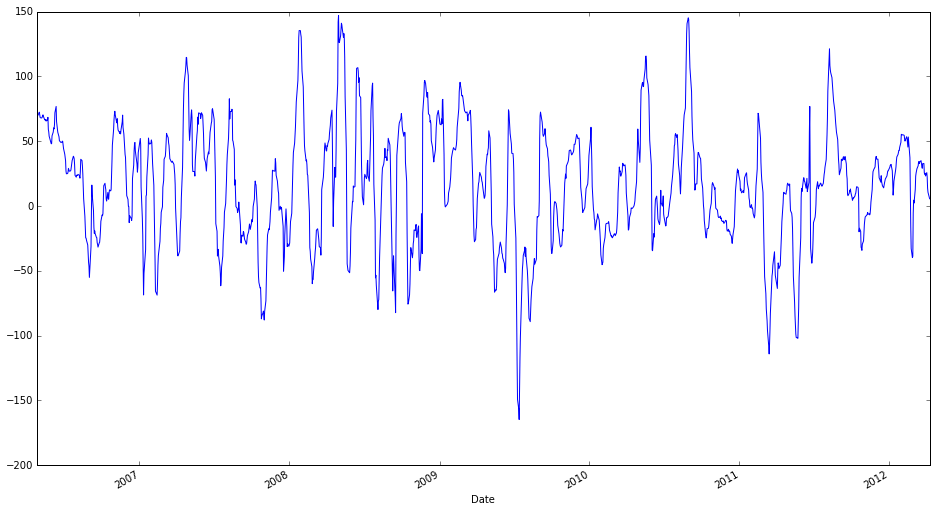

In [9]:
yport.plot(figsize=(16,9))

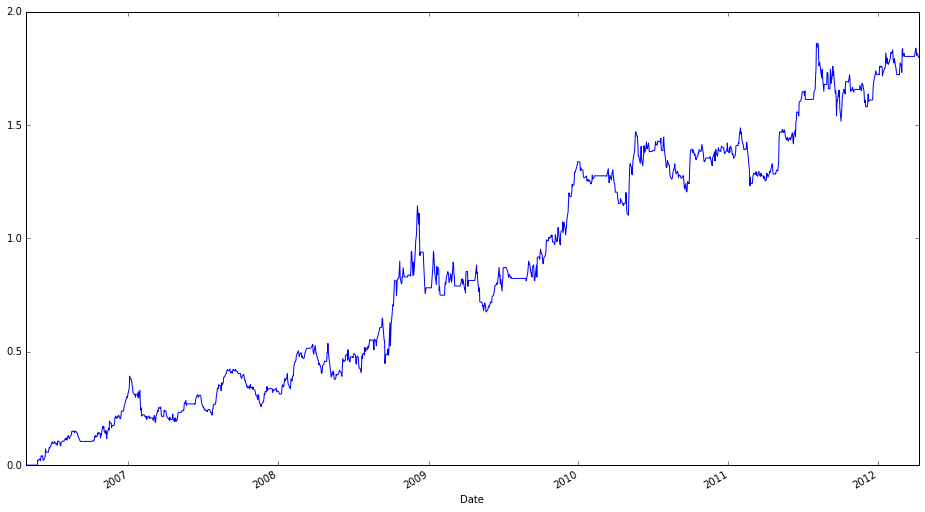

In [283]:
((1 + ret).cumprod() - 1).plot(figsize=(16,9))

In [161]:
# Ex 3.2 - Bollinger bands

entryZscore = 1
exitZscore = 0

longsEntry = zScore < -entryZscore
longsExit = zScore >= exitZscore
shortsEntry = zScore > entryZscore
shortsExit = zScore <= exitZscore

unitsLong = pd.Series(data=np.nan, index=zScore.index)
unitsShort = pd.Series(data=np.nan, index=zScore.index)

unitsLong[0] = 0
unitsLong[longsEntry] = 1
unitsLong[longsExit] = 0
unitsLong = unitsLong.fillna(method='ffill')

unitsShort[0] = 0
unitsShort[shortsEntry] = -1
unitsShort[shortsExit] = 0
unitsShort = unitsShort.fillna(method='ffill')

units = unitsLong + unitsShort

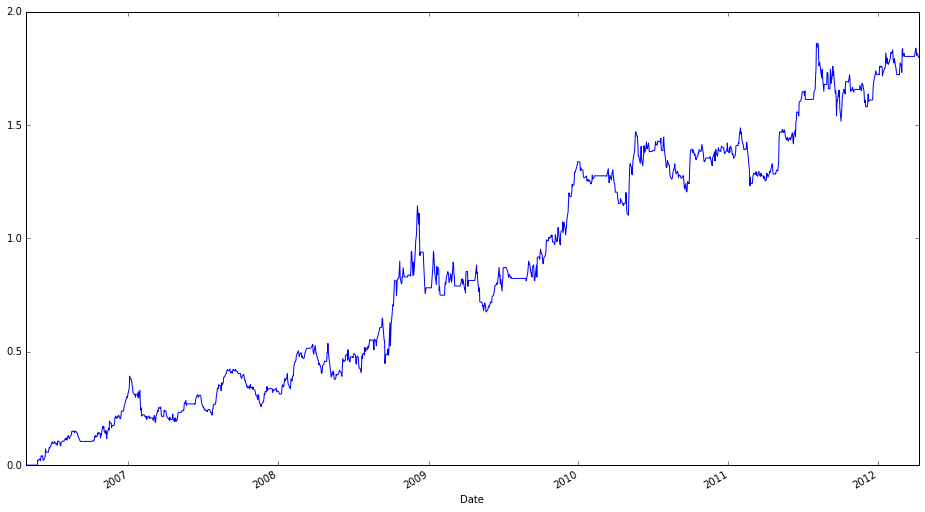

In [274]:
positions = units * weights * y2
pnl = (positions.shift(1) * y2.pct_change()).sum(axis=1)
grossMktVal = positions.abs().sum(axis=1)
ret = pnl / grossMktVal.shift(1)
ret = ret.fillna(value=0)
((1 + ret).cumprod() - 1).plot(figsize=(16,9))

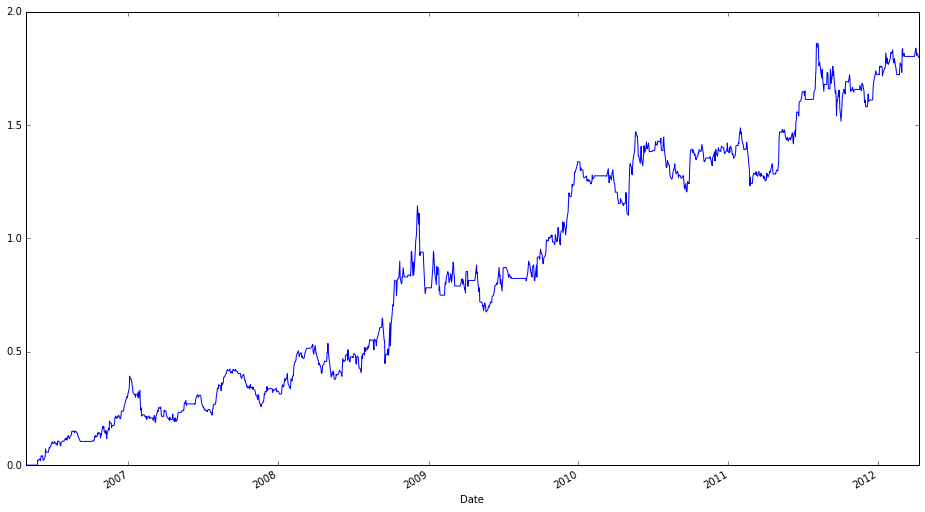

In [276]:
import portfolio

return_struct = portfolio.portfolio_returns(y2, weights, units)
ret = return_struct[0]
((1 + ret).cumprod() - 1).plot(figsize=(16,9))